<a href="https://colab.research.google.com/github/BrianKipngeno/Potato_disease_classification/blob/main/Potato_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
import zipfile
import os


In [ ]:
#Define the path to the uploaded zip file and the extraction path
zip_file_path = '/content/Potato disease.zip'  # Path to the zip file
extract_to_path = '/content/dataset/'  # Path where you want to extract the contents

In [ ]:
# Verify file path - You may need to adjust the path based on where you've uploaded the file
zip_file_path = '/content/Potato disease.zip'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
    print(f"File '{zip_file_path}' extracted successfully to '/content/dataset'.")
except zipfile.BadZipFile:
    print(f"Error: File '{zip_file_path}' is not a valid zip file. Please check the file and upload a correct zip archive.")
except FileNotFoundError:
    print(f"Error: File '{zip_file_path}' not found. Please ensure the file is uploaded to the correct location.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Error: File '/content/Potato disease.zip' is not a valid zip file. Please check the file and upload a correct zip archive.


In [ ]:
# Unzip the file
import zipfile
with zipfile.ZipFile('/content/Potato disease.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

BadZipFile: File is not a zip file

In [ ]:
# List the extracted files and directories
os.listdir('/content/dataset')

In [ ]:
# Set parameters
IMAGE_SIZE = 256  # You can adjust this based on your dataset
BATCH_SIZE = 32   # Adjust batch size as needed

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/Potato disease",  # Correct path where the dataset was extracted
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Check the class names to ensure everything is loaded correctly
print(dataset.class_names)

Found 2152 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
class_names = dataset.class_names
class_names

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

**Visualize some of the images from our dataset**

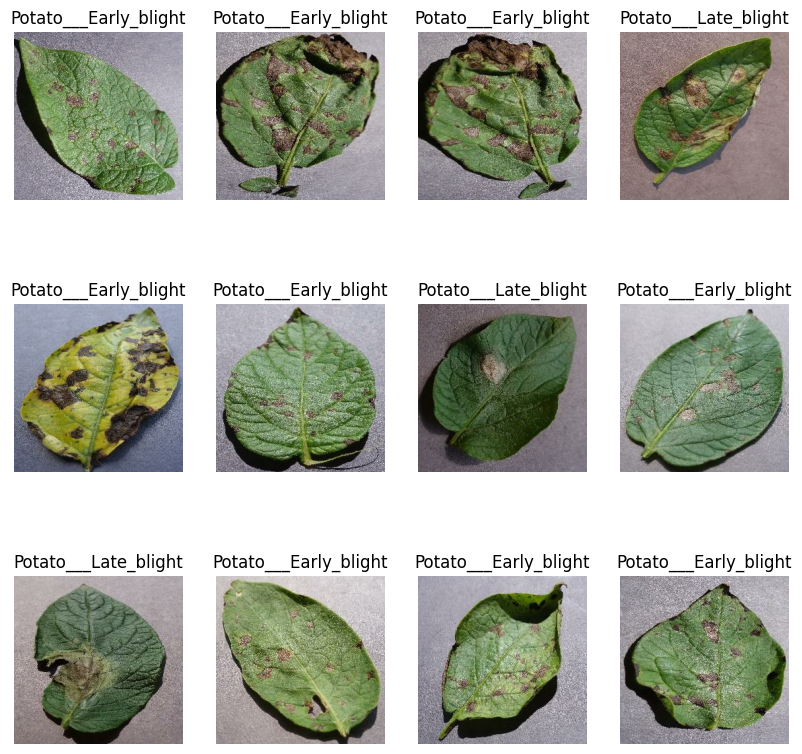

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Function to Split Dataset**

Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:

len(dataset)

In [ ]:
train_size = 0.8
len(dataset)*train_size

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

In [ ]:
val_size=0.1
len(dataset)*val_size

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

In [ ]:
len(val_ds)

In [ ]:
len(test_ds)

**Cache, Shuffle, and Prefetch the Dataset**

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).

This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256).

You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions.

At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
], name="resize_and_rescale")


**Data Augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

Applying Data Augmentation to the train dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the model

**Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [ ]:
resize_and_rescale.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,228,939 (42.84 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,485,960 (28.56 MB)

**Compiling the Model**

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - accuracy: 0.9899 - loss: 0.0249 - val_accuracy: 0.9219 - val_loss: 0.3106
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.9892 - loss: 0.0268 - val_accuracy: 0.9896 - val_loss: 0.0273
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - accuracy: 0.9965 - loss: 0.0127 - val_accuracy: 0.9271 - val_loss: 0.3305
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.9823 - loss: 0.0655 - val_accuracy: 0.9167 - val_loss: 0.3034
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.9948 - loss: 0.0221 - val_accuracy: 0.9844 - val_loss: 0.0391
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.9957 - loss: 0.0155 - val_accuracy: 0.9427 - val_loss: 0.1030
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9913 - loss: 0.0245 - val_accuracy: 0.9896 - val_loss: 0.0251
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.9942 - loss: 0.0158 - val_accu

In [ ]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9791 - loss: 0.1292


In [ ]:
scores

[0.06404666602611542, 0.98828125]

**Plotting the Accuracy and Loss Curves**

In [ ]:
history


In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.029244618490338326,
 0.03218208998441696,
 0.027424238622188568,
 0.04917968064546585,
 0.017090557143092155]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

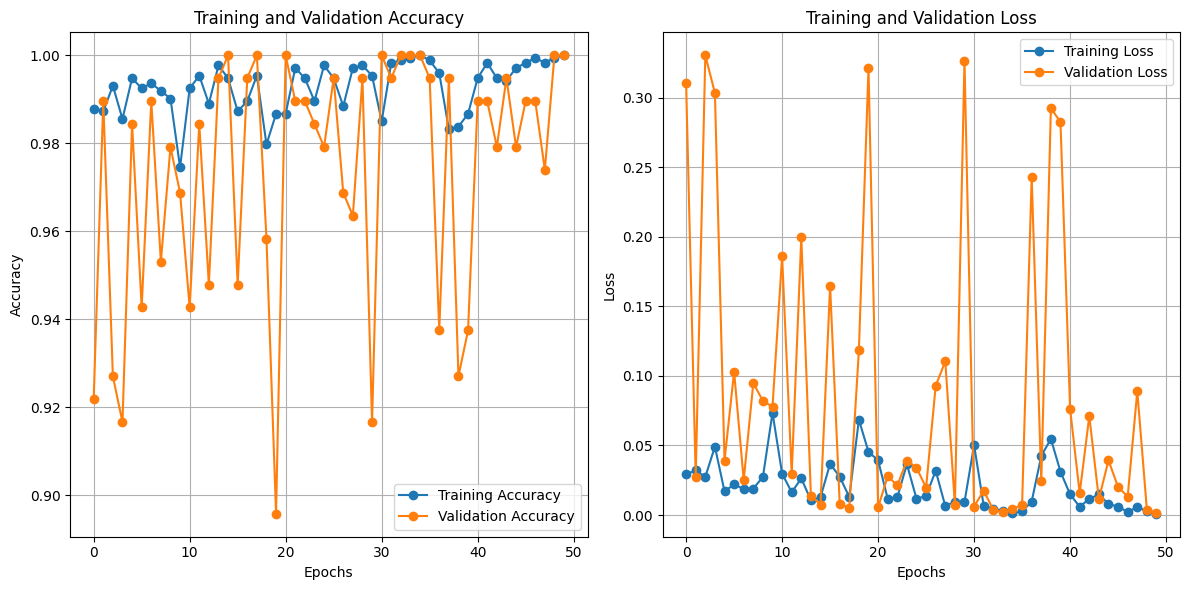

In [ ]:
# Number of epochs used during training
EPOCHS = len(history.history['loss'])

# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy', marker='o')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss', marker='o')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

plt.tight_layout()
plt.show()


**Run prediction on a sample image**

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
predicted label: Potato___Early_blight


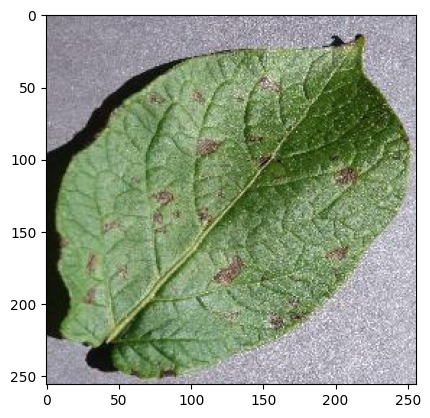

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Writing a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


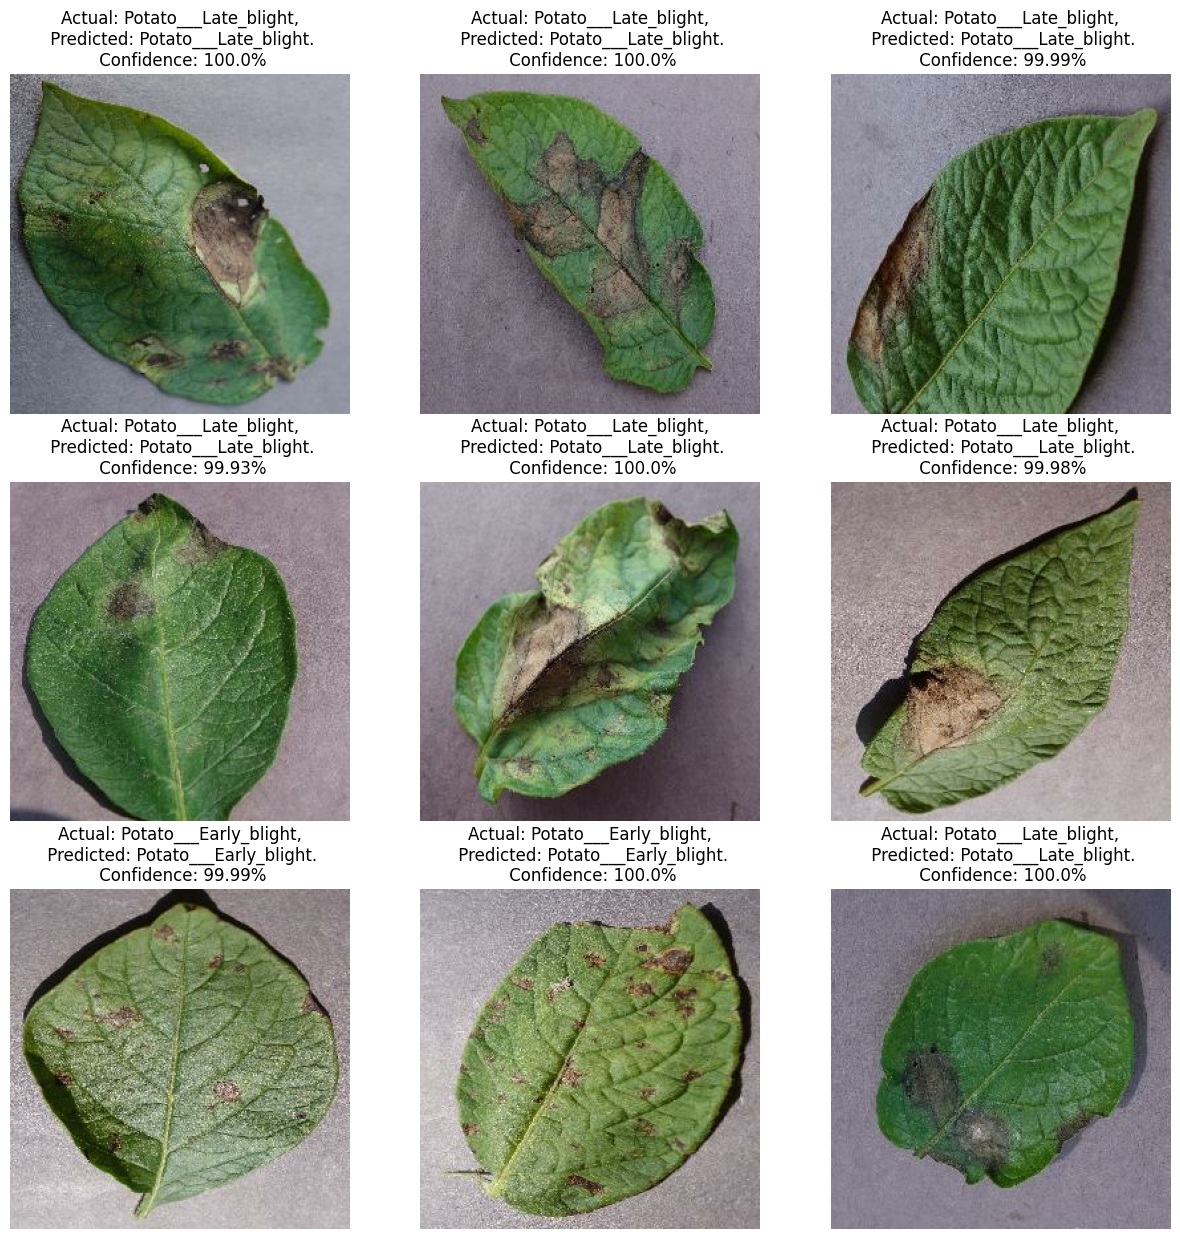

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

**Saving the Model**

We append the model to the list of models as a new version

In [99]:
model_save_path = "/content/saved_models/version_1.keras"
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Model saved to: /content/saved_models/version_1.keras


In [100]:
from google.colab import files

files.download(model_save_path)  # For the model file
# files.download(zip_path)  # Uncomment to download the compressed model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>